# Pre Processing

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
col_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label","difficulty_level"]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/NSL-KDD/KDDTrain+.txt",header=None, names=col_names)
data_test = pd.read_csv("/content/drive/MyDrive/NSL-KDD/KDDTest+.txt",header=None, names=col_names)


In [ ]:
data

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,difficulty_level
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,184,25,1.0,1.0,0.0,0.0,0.14,0.06,0.00,255,25,0.10,0.06,0.00,0.00,1.00,1.00,0.00,0.00,neptune,20
125969,8,udp,private,SF,105,145,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,255,244,0.96,0.01,0.01,0.00,0.00,0.00,0.00,0.00,normal,21
125970,0,tcp,smtp,SF,2231,384,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.00,0.00,0.00,255,30,0.12,0.06,0.00,0.00,0.72,0.00,0.01,0.00,normal,18
125971,0,tcp,klogin,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,144,8,1.0,1.0,0.0,0.0,0.06,0.05,0.00,255,8,0.03,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,20


In [ ]:
data.drop(['difficulty_level'],axis=1,inplace=True)
data_test.drop(['difficulty_level'],axis=1,inplace=True)
data.shape

(125973, 42)

In [ ]:
data['label'].value_counts()
data_test['label'].value_counts()

normal             9711
neptune            4657
guess_passwd       1231
mscan               996
warezmaster         944
apache2             737
satan               735
processtable        685
smurf               665
back                359
snmpguess           331
saint               319
mailbomb            293
snmpgetattack       178
portsweep           157
ipsweep             141
httptunnel          133
nmap                 73
pod                  41
buffer_overflow      20
multihop             18
named                17
ps                   15
sendmail             14
xterm                13
rootkit              13
teardrop             12
xlock                 9
land                  7
xsnoop                4
ftp_write             3
perl                  2
phf                   2
loadmodule            2
worm                  2
sqlattack             2
udpstorm              2
imap                  1
Name: label, dtype: int64

In [ ]:
def change_label(df):
  df.label.replace(['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm'],'Dos',inplace=True)
  df.label.replace(['ftp_write','guess_passwd','httptunnel','imap','multihop','named','phf','sendmail',
       'snmpgetattack','snmpguess','spy','warezclient','warezmaster','xlock','xsnoop'],'R2L',inplace=True)
  df.label.replace(['ipsweep','mscan','nmap','portsweep','saint','satan'],'Probe',inplace=True)
  df.label.replace(['buffer_overflow','loadmodule','perl','ps','rootkit','sqlattack','xterm'],'U2R',inplace=True)

In [ ]:
change_label(data)
change_label(data_test)

In [ ]:
data.label.value_counts()

normal    67343
Dos       45927
Probe     11656
R2L         995
U2R          52
Name: label, dtype: int64

In [ ]:
data_test.label.value_counts()

normal    9711
Dos       7460
R2L       2885
Probe     2421
U2R         67
Name: label, dtype: int64

In [ ]:
data.label.replace({"normal":0, "Dos":1, "Probe":1, "R2L":1, "U2R":1}, inplace=True)
data_test.label.replace({"normal":0, "Dos":1, "Probe":1, "R2L":1, "U2R":1}, inplace=True)

In [ ]:
data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,0
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,0
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,1
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,0
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0


# Encoding

In [ ]:
pip install --upgrade category_encoders

     |████████████████████████████████| 80 kB 6.9 MB/s 


In [ ]:
import category_encoders
from category_encoders import LeaveOneOutEncoder

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
features = ["protocol_type", "service", "flag"]
targ_enc = LeaveOneOutEncoder(cols=features)
targ_enc.fit(data[features], data['label'])
    
data = data.join(targ_enc.transform(data[features]).add_suffix('_targ'))
data_test = data_test.join(targ_enc.transform(data_test[features]).add_suffix('_targ'))
    
newdata = data.drop(features, axis=1)
newdata_test = data_test.drop(features, axis=1)

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [ ]:
newdata.shape

(125973, 42)

# Scaling

In [ ]:
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler

In [ ]:
numeric_col = newdata.select_dtypes(include='number').columns

In [ ]:
rbs_scaler = RobustScaler()
for i in numeric_col:
    arr = newdata[i]
    arr = np.array(arr)
    newdata[i] = rbs_scaler.fit_transform(arr.reshape(len(arr),1))
    arr2 = newdata_test[i]
    arr2 = np.array(arr2)
    newdata_test[i] = rbs_scaler.transform(arr2.reshape(len(arr2),1))

# X Y Dataset 

In [ ]:
Y_train = newdata.label
X_train = newdata.drop("label",1)
Y_test = newdata_test.label
X_test = newdata_test.drop("label",1)

In [ ]:
X_train.shape

(125973, 41)

In [ ]:
Y_train.shape

(125973,)

In [ ]:
Y_train.head()

0    0.0
1    0.0
2    1.0
3    0.0
4    0.0
Name: label, dtype: float64

# Auto Encoder Model

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model

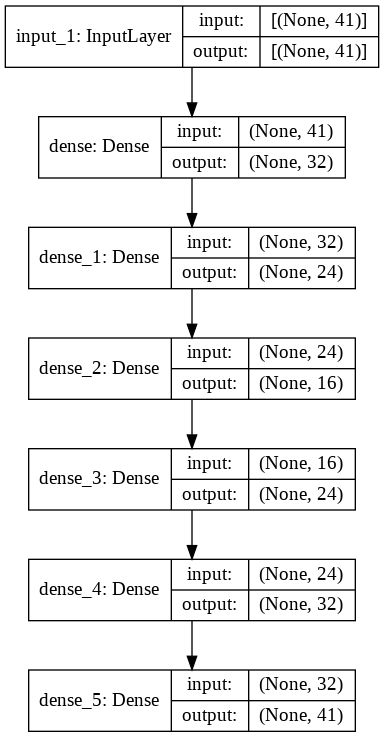

In [ ]:
# define encoder
n_inputs = X_train.shape[1]
# define encoder
visible = Input(shape=(n_inputs,))
# encoder level 1
e = Dense(32)(visible)
# encoder level 2
e = Dense(24)(e)
# bottleneck
n_bottleneck = 16
bottleneck = Dense(n_bottleneck)(e)
# define decoder, level 1
d = Dense(24)(bottleneck)
# decoder level 2
d = Dense(32)(d)
# output layer
output = Dense(n_inputs, activation='linear')(d)
# define autoencoder model
model = Model(inputs=visible, outputs=output)
# compile autoencoder model
model.compile(optimizer='adam', loss='mse', metrics=["accuracy"])
# plot the autoencoder
plot_model(model, 'autoencoder_compress.png', show_shapes=True)


In [ ]:
# fit the autoencoder model to reconstruct input
history = model.fit(X_train, X_train, epochs=100, batch_size=16, verbose=2, validation_split=0.2)


Epoch 1/100
6299/6299 - 10s - loss: 10026191.0000 - accuracy: 0.2445 - val_loss: 14824195.0000 - val_accuracy: 0.3254
Epoch 2/100
6299/6299 - 9s - loss: 9701487.0000 - accuracy: 0.2982 - val_loss: 18487070.0000 - val_accuracy: 0.2811
Epoch 3/100
6299/6299 - 8s - loss: 18622480.0000 - accuracy: 0.2355 - val_loss: 12864242.0000 - val_accuracy: 0.1975
Epoch 4/100
6299/6299 - 9s - loss: 4066874.0000 - accuracy: 0.1843 - val_loss: 14802881.0000 - val_accuracy: 0.1474
Epoch 5/100
6299/6299 - 8s - loss: 7037733.0000 - accuracy: 0.0818 - val_loss: 13512219.0000 - val_accuracy: 0.0783
Epoch 6/100
6299/6299 - 8s - loss: 10590739.0000 - accuracy: 0.0989 - val_loss: 21615148.0000 - val_accuracy: 0.1055
Epoch 7/100
6299/6299 - 9s - loss: 4193485.5000 - accuracy: 0.1341 - val_loss: 16033824.0000 - val_accuracy: 0.1209
Epoch 8/100
6299/6299 - 9s - loss: 6574327.0000 - accuracy: 0.1674 - val_loss: 13346698.0000 - val_accuracy: 0.2430
Epoch 9/100
6299/6299 - 8s - loss: 18520068.0000 - accuracy: 0.2073 

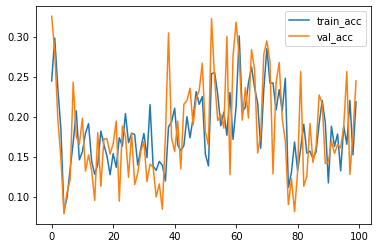

In [ ]:
from matplotlib import pyplot
# plot loss
# pyplot.plot(history.history['loss'], label='train loss')
# pyplot.plot(history.history['val_loss'], label='val_loss')
pyplot.plot(history.history['accuracy'], label='train_acc')
pyplot.plot(history.history['val_accuracy'], label='val_acc')
pyplot.legend()
pyplot.show()

In [ ]:
# define an encoder model (without the decoder)
encoder = Model(inputs=visible, outputs=bottleneck)
encoder.compile(optimizer='adam', loss='mse', metrics=["accuracy"])
plot_model(encoder, 'encoder_compress.png', show_shapes=True)
# save the encoder to file
encoder.save('encoder.h5')

# Classification

In [ ]:
from tensorflow.keras.models import load_model
encoder = load_model('encoder.h5')
# encode the train data
X_train_encode = encoder.predict(X_train)
# encode the test data
X_test_encode = encoder.predict(X_test)


In [ ]:
from keras.models import Sequential
# define the model
model = Sequential()
model.add(Dense(6, activation='relu', input_dim=16))
model.add(Dense(1, activation="sigmoid"))
# fit the model on the training set
model.compile(optimizer='adam', loss='mse', metrics=["accuracy"])
history = model.fit(X_train_encode, Y_train, epochs=100, batch_size=16, verbose=2, validation_split=0.2)


Epoch 1/100
6299/6299 - 7s - loss: 0.0649 - accuracy: 0.9292 - val_loss: 0.0487 - val_accuracy: 0.9467
Epoch 2/100
6299/6299 - 6s - loss: 0.0411 - accuracy: 0.9541 - val_loss: 0.0395 - val_accuracy: 0.9545
Epoch 3/100
6299/6299 - 6s - loss: 0.0378 - accuracy: 0.9579 - val_loss: 0.0363 - val_accuracy: 0.9599
Epoch 4/100
6299/6299 - 6s - loss: 0.0359 - accuracy: 0.9605 - val_loss: 0.0353 - val_accuracy: 0.9605
Epoch 5/100
6299/6299 - 6s - loss: 0.0347 - accuracy: 0.9621 - val_loss: 0.0340 - val_accuracy: 0.9632
Epoch 6/100
6299/6299 - 6s - loss: 0.0342 - accuracy: 0.9627 - val_loss: 0.0353 - val_accuracy: 0.9613
Epoch 7/100
6299/6299 - 6s - loss: 0.0333 - accuracy: 0.9637 - val_loss: 0.0329 - val_accuracy: 0.9625
Epoch 8/100
6299/6299 - 6s - loss: 0.0327 - accuracy: 0.9645 - val_loss: 0.0316 - val_accuracy: 0.9659
Epoch 9/100
6299/6299 - 6s - loss: 0.0323 - accuracy: 0.9650 - val_loss: 0.0329 - val_accuracy: 0.9637
Epoch 10/100
6299/6299 - 6s - loss: 0.0319 - accuracy: 0.9656 - val_loss:

In [ ]:
from sklearn.metrics import accuracy_score
# make predictions on the test set
yhat = model.predict(X_test_encode)
yhat_pred=[]
for val in yhat:
    if (val<0.5):
        yhat_pred.append(0)
    else:
        yhat_pred.append(1)
# calculate classification accuracy
acc = accuracy_score(Y_test, yhat_pred)
print(acc)

0.7477821149751597


# Analysis

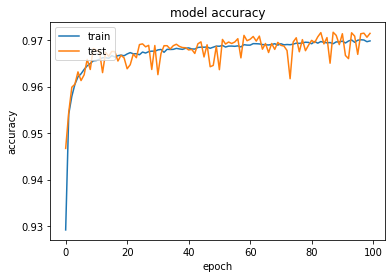

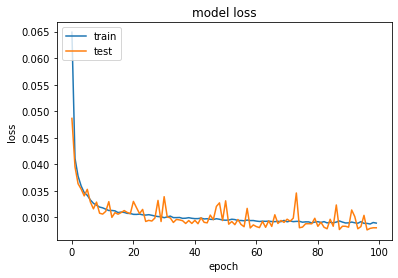

In [ ]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_test, yhat_pred)

array([[9460,  251],
       [5435, 7398]])

In [ ]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(Y_test, yhat_pred))
print(recall_score(Y_test, yhat_pred))

0.967185252974245
0.5764825060391179


In [ ]:
from sklearn.metrics import f1_score
f1_score(Y_test, yhat_pred)

0.7223903915633239

No Skill: ROC AUC=0.500
Auto Encoder: ROC AUC=0.792


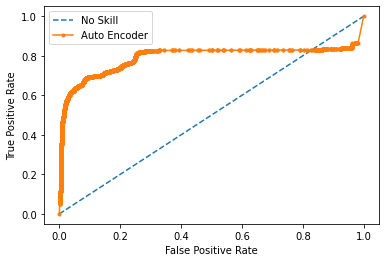

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

ns_probs = [0 for _ in range(len(Y_test))]
lr_probs = model.predict(X_test_encode)
ns_auc = roc_auc_score(Y_test, ns_probs)
lr_auc = roc_auc_score(Y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Auto Encoder: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(Y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(Y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Auto Encoder')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

Auto Encoder: f1=0.722 auc=0.881


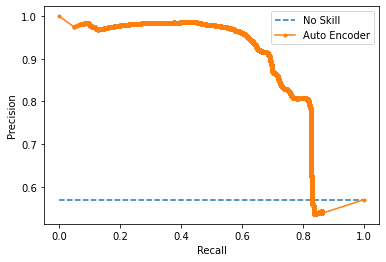

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

# predict probabilities
lr_probs = model.predict(X_test_encode)

lr_precision, lr_recall, _ = precision_recall_curve(Y_test, lr_probs)
lr_f1, lr_auc = f1_score(Y_test, yhat_pred), auc(lr_recall, lr_precision)
# summarize scores
print('Auto Encoder: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(Y_test[Y_test==1]) / len(Y_test)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Auto Encoder')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()